# 📊 Análise Completa do Modelo UNDER/OVER Total Kills - 2025

Este notebook contém análise completa do modelo de ML para prever se total_kills será OVER ou UNDER da média da liga, usando dados de 2025.

**Foco em Precisão**: Análises detalhadas de threshold, precision, recall e estratégias para maximizar acurácia nas apostas.

## 1. Preparação dos Dados

In [1]:
# Prepara dados diretamente (importa o módulo ao invés de subprocess)
import sys
import os
from pathlib import Path

# Ajusta path para importar módulos
current_dir = Path.cwd()
# Se não estiver no diretório modelo_2025, tenta encontrar
if not (current_dir / "data_preparation_2025.py").exists():
    possible_dirs = [
        current_dir / "modelo_2025",
        current_dir.parent / "modelo_2025",
        Path(__file__).parent if '__file__' in globals() else current_dir
    ]
    for ml_dir in possible_dirs:
        if ml_dir and (ml_dir / "data_preparation_2025.py").exists():
            os.chdir(ml_dir)
            sys.path.insert(0, str(ml_dir))
            break

print("Preparando dados...")
try:
    # Importa e executa diretamente
    from data_preparation_2025 import main as prep_main
    prep_main()
    print("Dados preparados com sucesso!")
except Exception as e:
    print(f"Erro ao preparar dados: {e}")
    print("Continuando com dados existentes (se já foram preparados)...")

Preparando dados...
PREPARAÇÃO DE DADOS PARA MODELO UNDER/OVER TOTAL_KILLS - 2025
Usando MÉDIA DA LIGA como target
Carregando dados de 2025 de c:\Users\Matheus\Documents\Repositorios\pinnacle\machine_learning\modelo_2025\data_2025_transformed.csv...
Dados carregados: 9806 partidas

Estatísticas por liga:
  AL: média=35.42, std=9.76, amostras=280
  ASI: média=34.12, std=8.50, amostras=42
  Asia Master: média=35.24, std=8.97, amostras=180
  CD: média=31.13, std=8.96, amostras=280
  CT: média=35.82, std=10.53, amostras=50
  DCup: média=31.17, std=9.13, amostras=75
  EBL: média=35.60, std=10.66, amostras=186
  EM: média=31.70, std=8.57, amostras=440
  EWC: média=28.33, std=6.36, amostras=33
  FST: média=29.40, std=8.87, amostras=35
  HC: média=38.27, std=8.96, amostras=200
  HLL: média=35.46, std=8.92, amostras=213
  HM: média=32.91, std=9.22, amostras=190
  HW: média=35.47, std=10.13, amostras=114
  IC: média=35.75, std=6.43, amostras=28
  LAS: média=37.25, std=9.86, amostras=489
  LCK: m

## 2. Carregamento dos Dados

In [2]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import os
import sys

# Tenta importar matplotlib e seaborn, se não estiver instalado, instala
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Instalando matplotlib e seaborn...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "seaborn", "-q", "--quiet"])
    import matplotlib.pyplot as plt
    import seaborn as sns

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, f1_score, precision_score, recall_score,
    accuracy_score, roc_auc_score
)

# Configuração
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Ajusta diretório de trabalho
current_dir = Path.cwd()
if not (current_dir / "data_preparation_2025.py").exists():
    possible_dirs = [
        current_dir / "modelo_2025",
        current_dir.parent / "modelo_2025"
    ]
    for path in possible_dirs:
        if path.exists() and (path / "data_preparation_2025.py").exists():
            os.chdir(path)
            current_dir = path
            break

DATA_DIR = current_dir / "data"

# Carrega dados
features_df = pd.read_csv(DATA_DIR / "features.csv")
labels = np.load(DATA_DIR / "labels.npy")

with open(DATA_DIR / "league_stats.pkl", "rb") as f:
    league_stats = pickle.load(f)

print(f"Features shape: {features_df.shape}")
print(f"Labels shape: {labels.shape}")
print(f"\nDistribuicao de labels:")
print(f"  UNDER (0): {np.sum(labels == 0)} ({np.sum(labels == 0)/len(labels)*100:.1f}%)")
print(f"  OVER (1): {np.sum(labels == 1)} ({np.sum(labels == 1)/len(labels)*100:.1f}%)")

Features shape: (9806, 59)
Labels shape: (9806,)

Distribuicao de labels:
  UNDER (0): 5348 (54.5%)
  OVER (1): 4458 (45.5%)


## 3. Análise Exploratória

In [3]:
# Estatísticas por liga
print("Estatísticas por liga:")
for league in sorted(league_stats.keys()):
    stats = league_stats[league]
    print(f"  {league:20s}: média={stats['mean']:5.2f}, std={stats['std']:5.2f}")

Estatísticas por liga:
  AL                  : média=35.42, std= 9.76
  ASI                 : média=34.12, std= 8.50
  Asia Master         : média=35.24, std= 8.97
  CD                  : média=31.13, std= 8.96
  CT                  : média=35.82, std=10.53
  DCup                : média=31.17, std= 9.13
  EBL                 : média=35.60, std=10.66
  EM                  : média=31.70, std= 8.57
  EWC                 : média=28.33, std= 6.36
  FST                 : média=29.40, std= 8.87
  HC                  : média=38.27, std= 8.96
  HLL                 : média=35.46, std= 8.92
  HM                  : média=32.91, std= 9.22
  HW                  : média=35.47, std=10.13
  IC                  : média=35.75, std= 6.43
  LAS                 : média=37.25, std= 9.86
  LCK                 : média=28.81, std= 7.65
  LCKC                : média=31.37, std= 9.45
  LCP                 : média=27.53, std= 7.85
  LEC                 : média=27.08, std= 8.47
  LFL                 : média=28.93, 

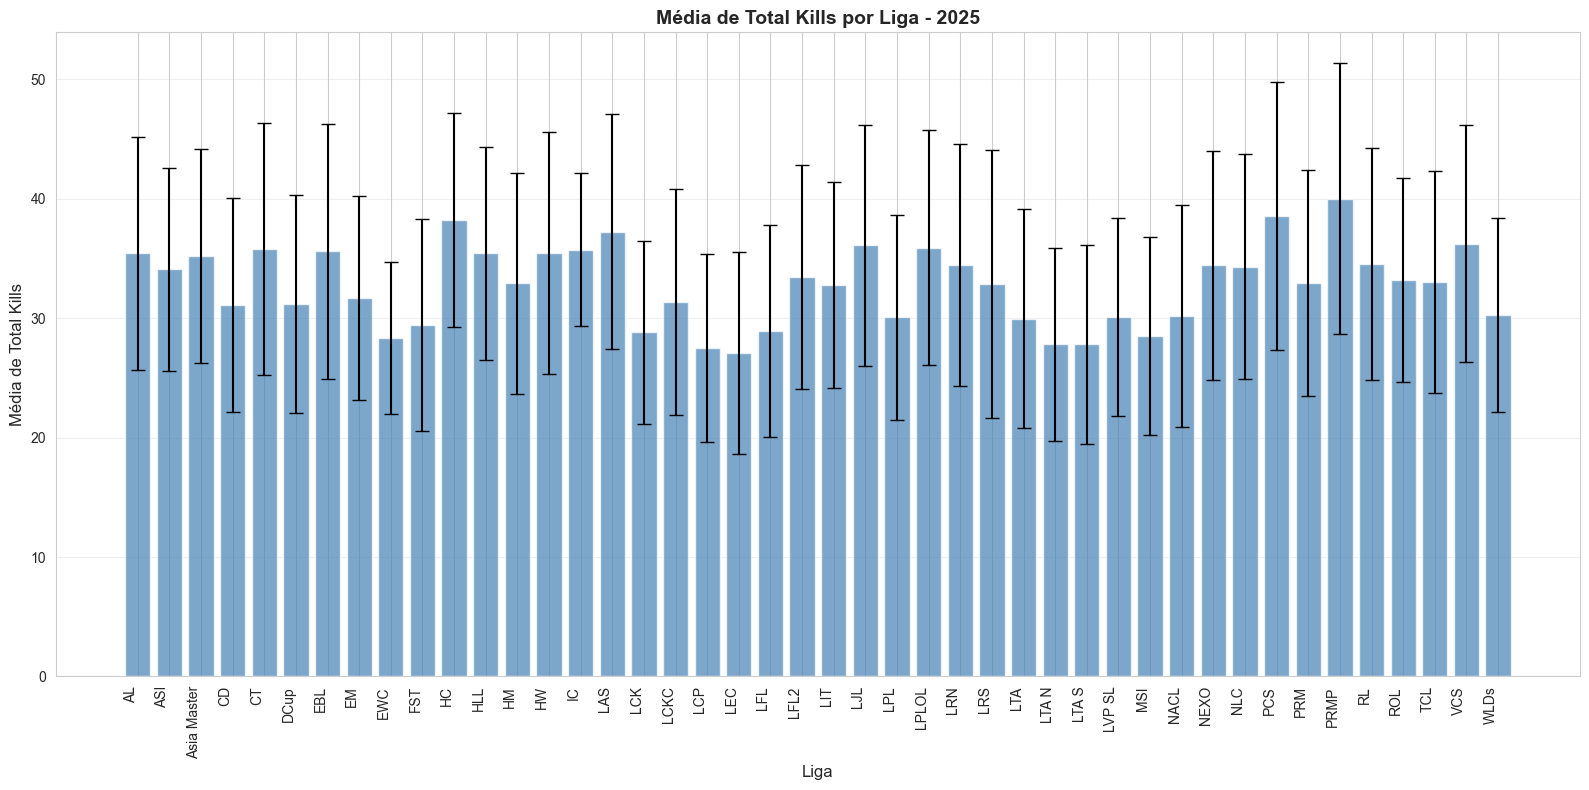


Variação entre ligas: 12.93 kills
Total de ligas: 44


In [4]:
# Visualização das médias por liga
leagues = sorted(league_stats.keys())
means = [league_stats[lg]['mean'] for lg in leagues]
stds = [league_stats[lg]['std'] for lg in leagues]

plt.figure(figsize=(16, 8))
plt.bar(range(len(leagues)), means, yerr=stds, capsize=5, alpha=0.7, color='steelblue')
plt.xlabel('Liga', fontsize=12)
plt.ylabel('Média de Total Kills', fontsize=12)
plt.title('Média de Total Kills por Liga - 2025', fontsize=14, fontweight='bold')
plt.xticks(range(len(leagues)), leagues, rotation=90, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nVariação entre ligas: {max(means) - min(means):.2f} kills")
print(f"Total de ligas: {len(leagues)}")

## 4. Treinamento do Modelo

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepara dados
X = features_df.values
y = labels

# Split train/test - guarda índices para análise posterior
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, indices, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)} amostras")
print(f"Test: {len(X_test)} amostras")
print(f"\nDistribuição train: UNDER={np.sum(y_train == 0)}, OVER={np.sum(y_train == 1)}")
print(f"Distribuição test: UNDER={np.sum(y_test == 0)}, OVER={np.sum(y_test == 1)}")

Train: 7844 amostras
Test: 1962 amostras

Distribuição train: UNDER=4278, OVER=3566
Distribuição test: UNDER=1070, OVER=892


In [6]:
# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treina modelo
model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train_scaled, y_train)

# Predições
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Modelo treinado com sucesso!")

Modelo treinado com sucesso!


## 5. Métricas de Performance

In [7]:
# Métricas básicas
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("=" * 60)
print("MÉTRICAS DO MODELO")
print("=" * 60)
print(f"\nAccuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"ROC-AUC:    {roc_auc:.4f}")
print(f"Precision:  {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:     {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:   {f1:.4f}")

MÉTRICAS DO MODELO

Accuracy:  0.6193 (61.93%)
ROC-AUC:    0.6833
Precision:  0.5735 (57.35%)
Recall:     0.6345 (63.45%)
F1-Score:   0.6024


In [8]:
# Classification Report detalhado
print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['UNDER', 'OVER']))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

       UNDER       0.67      0.61      0.63      1070
        OVER       0.57      0.63      0.60       892

    accuracy                           0.62      1962
   macro avg       0.62      0.62      0.62      1962
weighted avg       0.62      0.62      0.62      1962



## 6. Análise de Threshold - FOCO EM PRECISÃO

Esta seção analisa diferentes thresholds para maximizar a precisão das predições.

In [9]:
# Análise detalhada de threshold
thresholds_range = np.arange(0.1, 1.0, 0.01)
results = []

for threshold in thresholds_range:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Métricas gerais
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Métricas por classe
    cm = confusion_matrix(y_test, y_pred_thresh)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Precision por classe
        precision_under = tn / (tn + fn) if (tn + fn) > 0 else 0
        precision_over = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        results.append({
            'threshold': threshold,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'precision_under': precision_under,
            'precision_over': precision_over,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn
        })

results_df = pd.DataFrame(results)

# Encontra melhores thresholds
best_acc_idx = results_df['accuracy'].idxmax()
best_prec_idx = results_df['precision'].idxmax()
best_f1_idx = results_df['f1'].idxmax()

print("=" * 70)
print("ANÁLISE DE THRESHOLD - FOCO EM PRECISÃO")
print("=" * 70)
print(f"\nMelhor Accuracy: {results_df.loc[best_acc_idx, 'threshold']:.3f}")
print(f"  Accuracy: {results_df.loc[best_acc_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_acc_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_acc_idx, 'recall']:.4f}")

print(f"\nMelhor Precision: {results_df.loc[best_prec_idx, 'threshold']:.3f}")
print(f"  Accuracy: {results_df.loc[best_prec_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_prec_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_prec_idx, 'recall']:.4f}")

print(f"\nMelhor F1-Score: {results_df.loc[best_f1_idx, 'threshold']:.3f}")
print(f"  Accuracy: {results_df.loc[best_f1_idx, 'accuracy']:.4f}")
print(f"  Precision: {results_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"  Recall: {results_df.loc[best_f1_idx, 'recall']:.4f}")

ANÁLISE DE THRESHOLD - FOCO EM PRECISÃO

Melhor Accuracy: 0.560
  Accuracy: 0.6346
  Precision: 0.6184
  Recall: 0.5123

Melhor Precision: 0.960
  Accuracy: 0.5484
  Precision: 1.0000
  Recall: 0.0067

Melhor F1-Score: 0.310
  Accuracy: 0.5556
  Precision: 0.5061
  Recall: 0.9249


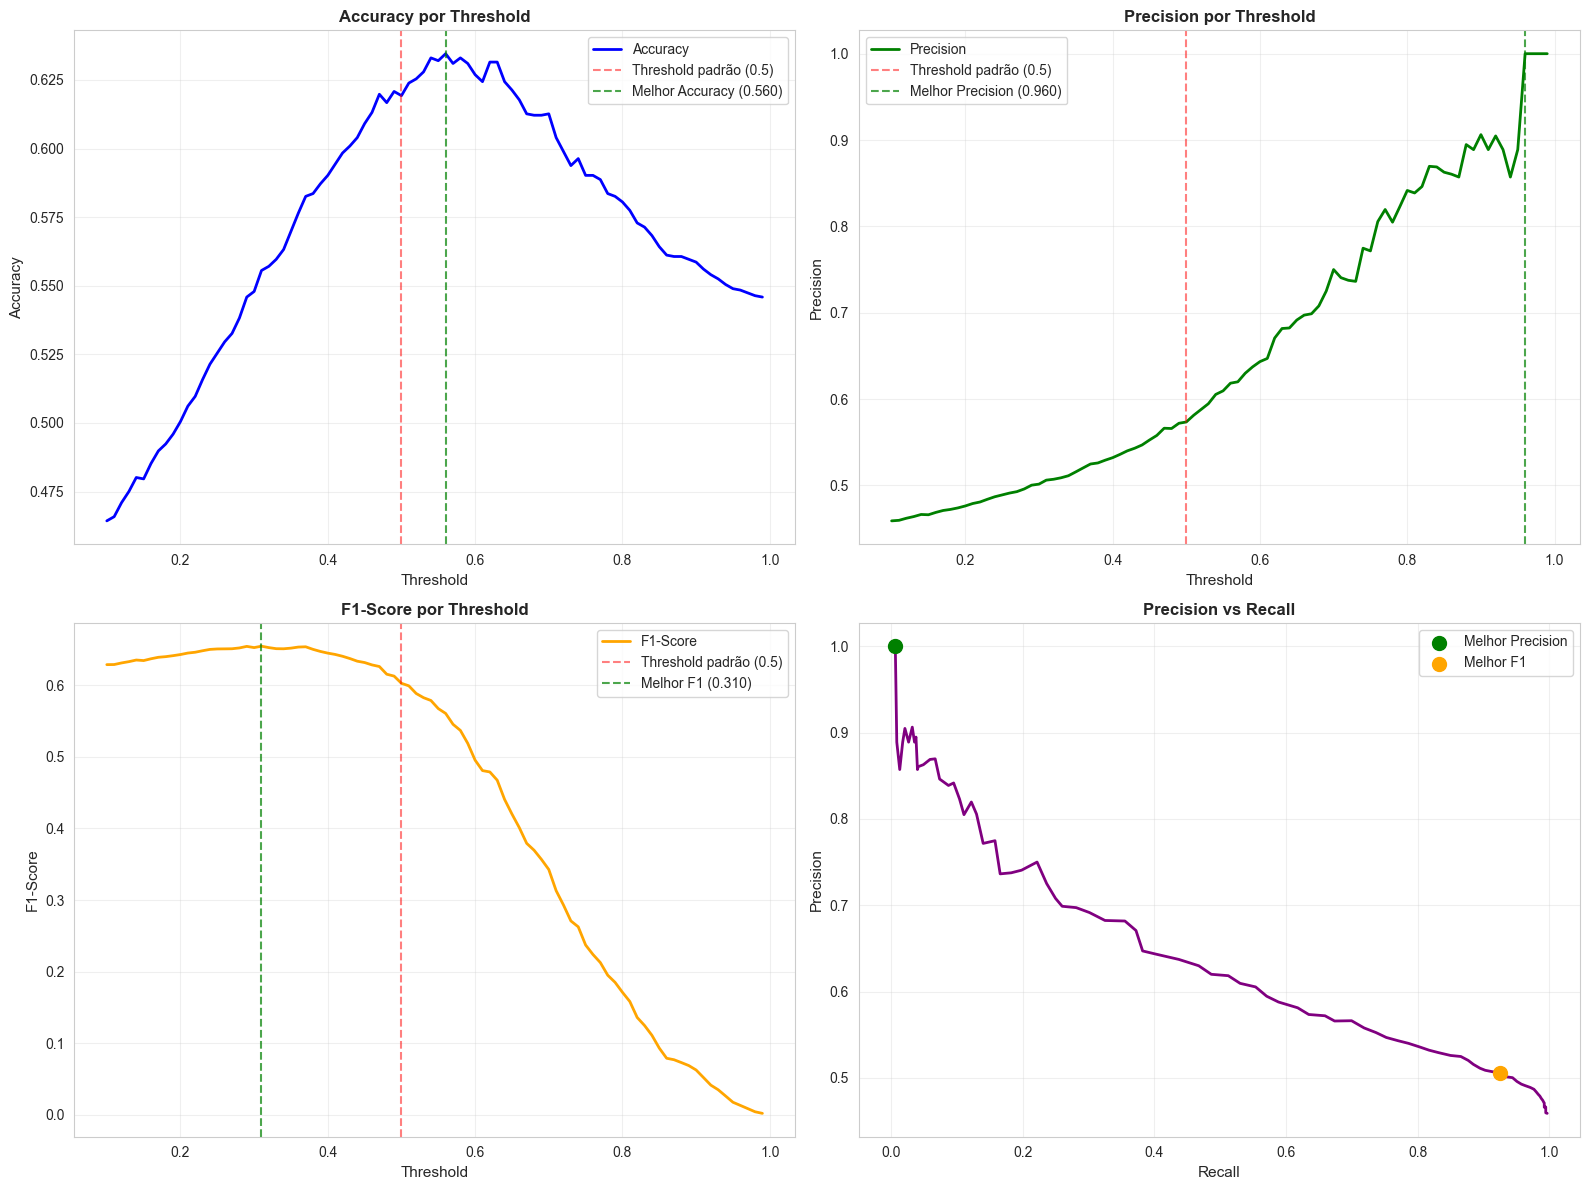

In [10]:
# Visualização: Métricas por Threshold
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy por threshold
axes[0, 0].plot(results_df['threshold'], results_df['accuracy'], 'b-', linewidth=2, label='Accuracy')
axes[0, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold padrão (0.5)')
axes[0, 0].axvline(x=results_df.loc[best_acc_idx, 'threshold'], color='green', 
                   linestyle='--', alpha=0.7, label=f'Melhor Accuracy ({results_df.loc[best_acc_idx, "threshold"]:.3f})')
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy por Threshold', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision por threshold
axes[0, 1].plot(results_df['threshold'], results_df['precision'], 'g-', linewidth=2, label='Precision')
axes[0, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold padrão (0.5)')
axes[0, 1].axvline(x=results_df.loc[best_prec_idx, 'threshold'], color='green', 
                   linestyle='--', alpha=0.7, label=f'Melhor Precision ({results_df.loc[best_prec_idx, "threshold"]:.3f})')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision por Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# F1-Score por threshold
axes[1, 0].plot(results_df['threshold'], results_df['f1'], 'orange', linewidth=2, label='F1-Score')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold padrão (0.5)')
axes[1, 0].axvline(x=results_df.loc[best_f1_idx, 'threshold'], color='green', 
                   linestyle='--', alpha=0.7, label=f'Melhor F1 ({results_df.loc[best_f1_idx, "threshold"]:.3f})')
axes[1, 0].set_xlabel('Threshold', fontsize=11)
axes[1, 0].set_ylabel('F1-Score', fontsize=11)
axes[1, 0].set_title('F1-Score por Threshold', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Precision vs Recall
axes[1, 1].plot(results_df['recall'], results_df['precision'], 'purple', linewidth=2)
axes[1, 1].scatter(results_df.loc[best_prec_idx, 'recall'], results_df.loc[best_prec_idx, 'precision'], 
                   color='green', s=100, zorder=5, label=f'Melhor Precision')
axes[1, 1].scatter(results_df.loc[best_f1_idx, 'recall'], results_df.loc[best_f1_idx, 'precision'], 
                   color='orange', s=100, zorder=5, label=f'Melhor F1')
axes[1, 1].set_xlabel('Recall', fontsize=11)
axes[1, 1].set_ylabel('Precision', fontsize=11)
axes[1, 1].set_title('Precision vs Recall', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

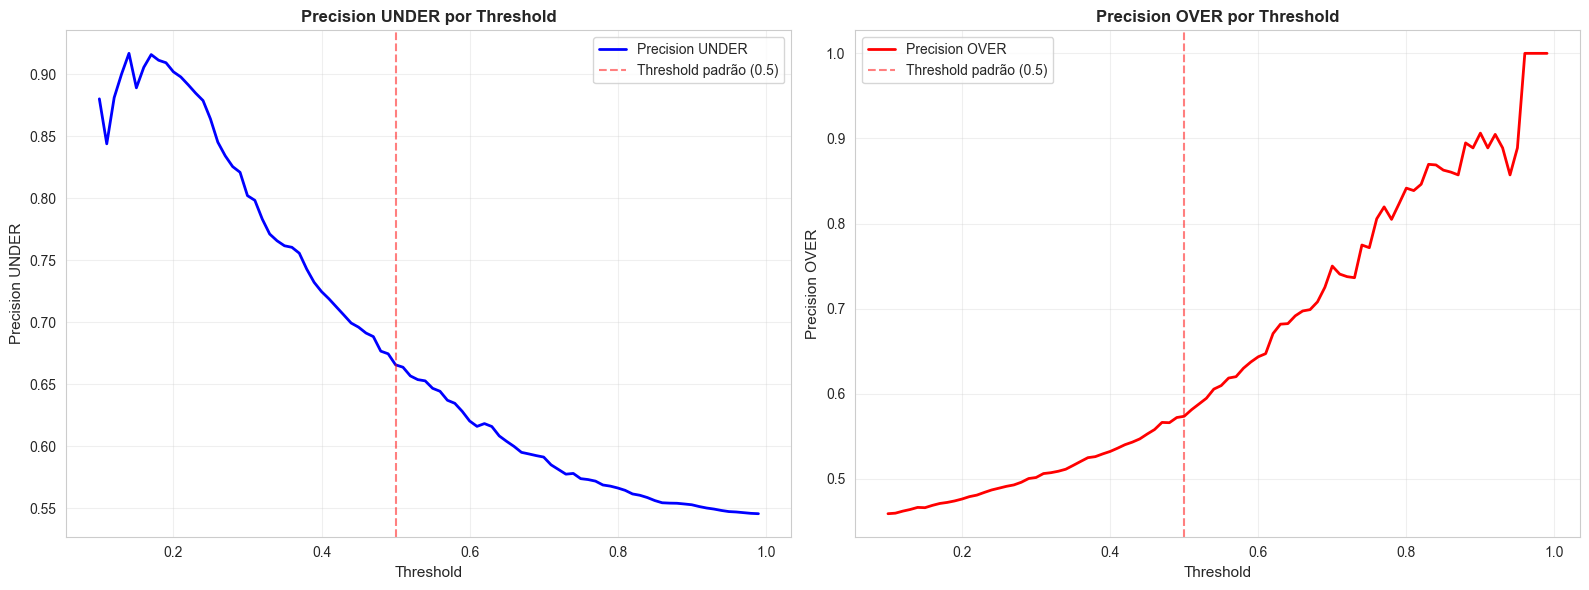


THRESHOLD ÓTIMO POR CLASSE

UNDER - Melhor Precision:
  Threshold: 0.140
  Precision: 0.9167 (91.67%)
  Recall: 0.9944

OVER - Melhor Precision:
  Threshold: 0.960
  Precision: 1.0000 (100.00%)
  Recall: 0.0067


In [11]:
# Análise de Precision por Classe (UNDER e OVER) em diferentes thresholds
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision UNDER por threshold
axes[0].plot(results_df['threshold'], results_df['precision_under'], 'b-', linewidth=2, label='Precision UNDER')
axes[0].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold padrão (0.5)')
axes[0].set_xlabel('Threshold', fontsize=11)
axes[0].set_ylabel('Precision UNDER', fontsize=11)
axes[0].set_title('Precision UNDER por Threshold', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision OVER por threshold
axes[1].plot(results_df['threshold'], results_df['precision_over'], 'r-', linewidth=2, label='Precision OVER')
axes[1].axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Threshold padrão (0.5)')
axes[1].set_xlabel('Threshold', fontsize=11)
axes[1].set_ylabel('Precision OVER', fontsize=11)
axes[1].set_title('Precision OVER por Threshold', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Encontra threshold ótimo para cada classe
best_prec_under_idx = results_df['precision_under'].idxmax()
best_prec_over_idx = results_df['precision_over'].idxmax()

print("\n" + "=" * 70)
print("THRESHOLD ÓTIMO POR CLASSE")
print("=" * 70)
print(f"\nUNDER - Melhor Precision:")
print(f"  Threshold: {results_df.loc[best_prec_under_idx, 'threshold']:.3f}")
print(f"  Precision: {results_df.loc[best_prec_under_idx, 'precision_under']:.4f} ({results_df.loc[best_prec_under_idx, 'precision_under']*100:.2f}%)")
print(f"  Recall: {results_df.loc[best_prec_under_idx, 'recall']:.4f}")

print(f"\nOVER - Melhor Precision:")
print(f"  Threshold: {results_df.loc[best_prec_over_idx, 'threshold']:.3f}")
print(f"  Precision: {results_df.loc[best_prec_over_idx, 'precision_over']:.4f} ({results_df.loc[best_prec_over_idx, 'precision_over']*100:.2f}%)")
print(f"  Recall: {results_df.loc[best_prec_over_idx, 'recall']:.4f}")

## 7. Análise de Thresholds Específicos para Apostas

Análise de thresholds específicos focados em maximizar precisão para apostas.

In [12]:
# Thresholds específicos para análise de apostas
betting_thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]

print("=" * 80)
print("ANÁLISE DE THRESHOLDS PARA APOSTAS - FOCO EM PRECISÃO")
print("=" * 80)

for threshold in betting_thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    
    # Métricas gerais
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh, zero_division=0)
    rec = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_thresh)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        # Precision por classe
        precision_under = tn / (tn + fn) if (tn + fn) > 0 else 0
        precision_over = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Número de predições
        n_pred_over = np.sum(y_pred_thresh == 1)
        n_pred_under = np.sum(y_pred_thresh == 0)
        
        print(f"\nThreshold: {threshold:.2f}")
        print(f"  Accuracy: {acc:.4f} ({acc*100:.2f}%)")
        print(f"  Precision Geral: {prec:.4f} ({prec*100:.2f}%)")
        print(f"  Recall: {rec:.4f} ({rec*100:.2f}%)")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Precision UNDER: {precision_under:.4f} ({precision_under*100:.2f}%)")
        print(f"  Precision OVER: {precision_over:.4f} ({precision_over*100:.2f}%)")
        print(f"  Predições OVER: {n_pred_over} ({n_pred_over/len(y_test)*100:.1f}%)")
        print(f"  Predições UNDER: {n_pred_under} ({n_pred_under/len(y_test)*100:.1f}%)")
        print(f"  Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
        
        # Recomendação
        if precision_over >= 0.70 or precision_under >= 0.70:
            print(f"  [RECOMENDADO] Alta precisão em pelo menos uma classe")
        elif precision_over >= 0.65 or precision_under >= 0.65:
            print(f"  [BOM] Boa precisão")
        else:
            print(f"  [CAUTELA] Precisão moderada")

ANÁLISE DE THRESHOLDS PARA APOSTAS - FOCO EM PRECISÃO

Threshold: 0.50
  Accuracy: 0.6193 (61.93%)
  Precision Geral: 0.5735 (57.35%)
  Recall: 0.6345 (63.45%)
  F1-Score: 0.6024
  Precision UNDER: 0.6656 (66.56%)
  Precision OVER: 0.5735 (57.35%)
  Predições OVER: 987 (50.3%)
  Predições UNDER: 975 (49.7%)
  Confusion Matrix: TN=649, FP=421, FN=326, TP=566
  [BOM] Boa precisão

Threshold: 0.55
  Accuracy: 0.6320 (63.20%)
  Precision Geral: 0.6095 (60.95%)
  Recall: 0.5303 (53.03%)
  F1-Score: 0.5671
  Precision UNDER: 0.6467 (64.67%)
  Precision OVER: 0.6095 (60.95%)
  Predições OVER: 776 (39.6%)
  Predições UNDER: 1186 (60.4%)
  Confusion Matrix: TN=767, FP=303, FN=419, TP=473
  [CAUTELA] Precisão moderada

Threshold: 0.60
  Accuracy: 0.6269 (62.69%)
  Precision Geral: 0.6434 (64.34%)
  Recall: 0.4025 (40.25%)
  F1-Score: 0.4952
  Precision UNDER: 0.6204 (62.04%)
  Precision OVER: 0.6434 (64.34%)
  Predições OVER: 558 (28.4%)
  Predições UNDER: 1404 (71.6%)
  Confusion Matrix: TN=871

## 8. Curva ROC

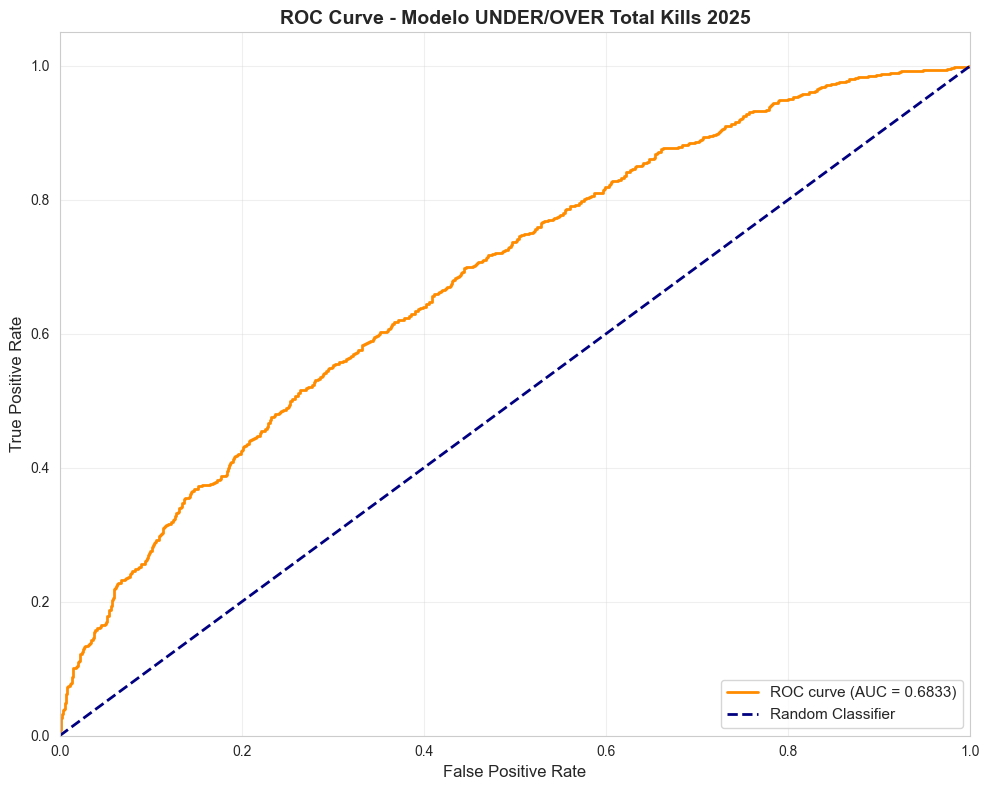


AUC-ROC: 0.6833


In [13]:
# Calcula curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plota curva ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Modelo UNDER/OVER Total Kills 2025', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC-ROC: {roc_auc:.4f}")

## 9. Precision-Recall Curve

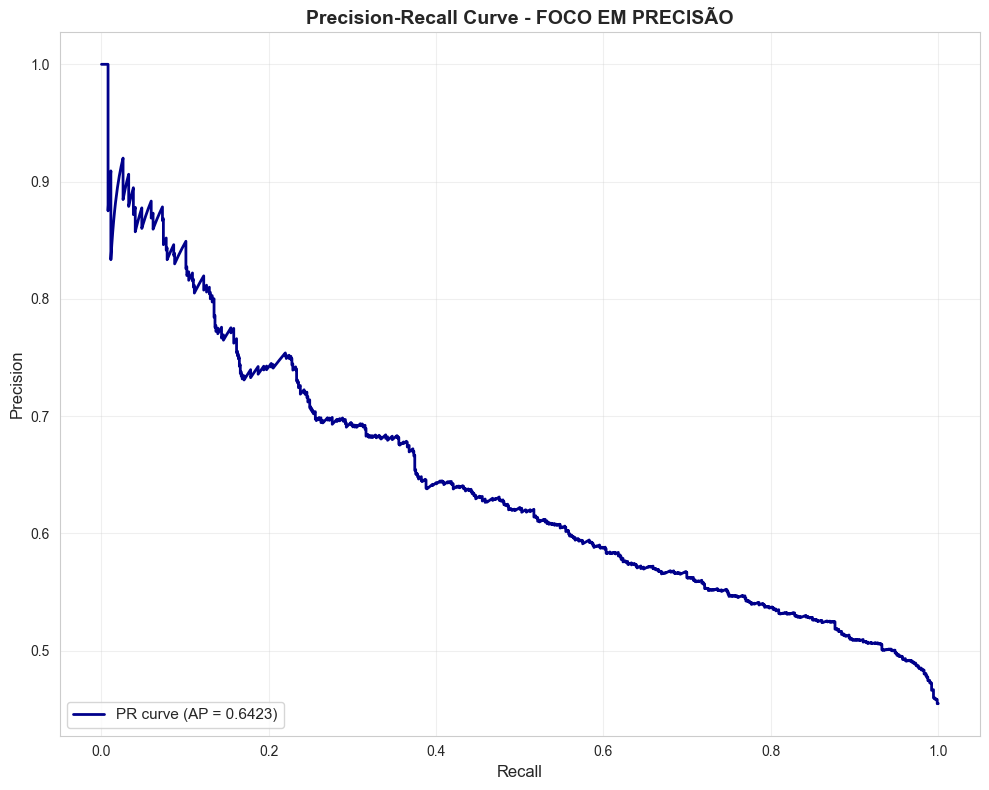


Average Precision: 0.6423


In [14]:
# Calcula Precision-Recall curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

# Plota Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall_curve, precision_curve, color='darkblue', lw=2, 
         label=f'PR curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - FOCO EM PRECISÃO', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAverage Precision: {avg_precision:.4f}")

## 10. Confusion Matrix

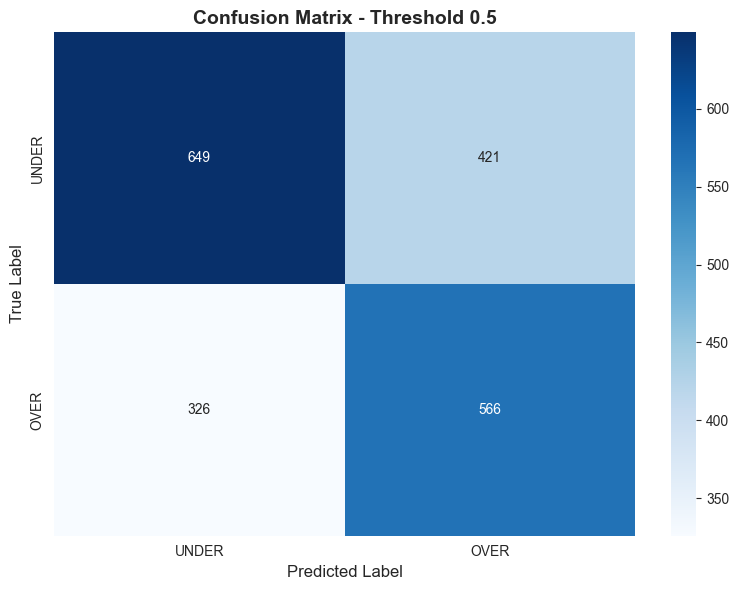


True Negatives (UNDER predito corretamente):  649
False Positives (OVER predito incorretamente): 421
False Negatives (UNDER predito incorretamente): 326
True Positives (OVER predito corretamente):     566

Taxa de acerto: 61.93%


In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plota confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['UNDER', 'OVER'], 
            yticklabels=['UNDER', 'OVER'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix - Threshold 0.5', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Métricas da confusion matrix
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (UNDER predito corretamente):  {tn}")
print(f"False Positives (OVER predito incorretamente): {fp}")
print(f"False Negatives (UNDER predito incorretamente): {fn}")
print(f"True Positives (OVER predito corretamente):     {tp}")
print(f"\nTaxa de acerto: {(tn + tp) / (tn + fp + fn + tp) * 100:.2f}%")

## 11. Distribuição de Probabilidades

C:\Users\Matheus\AppData\Local\Temp\ipykernel_34828\4142970034.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]],


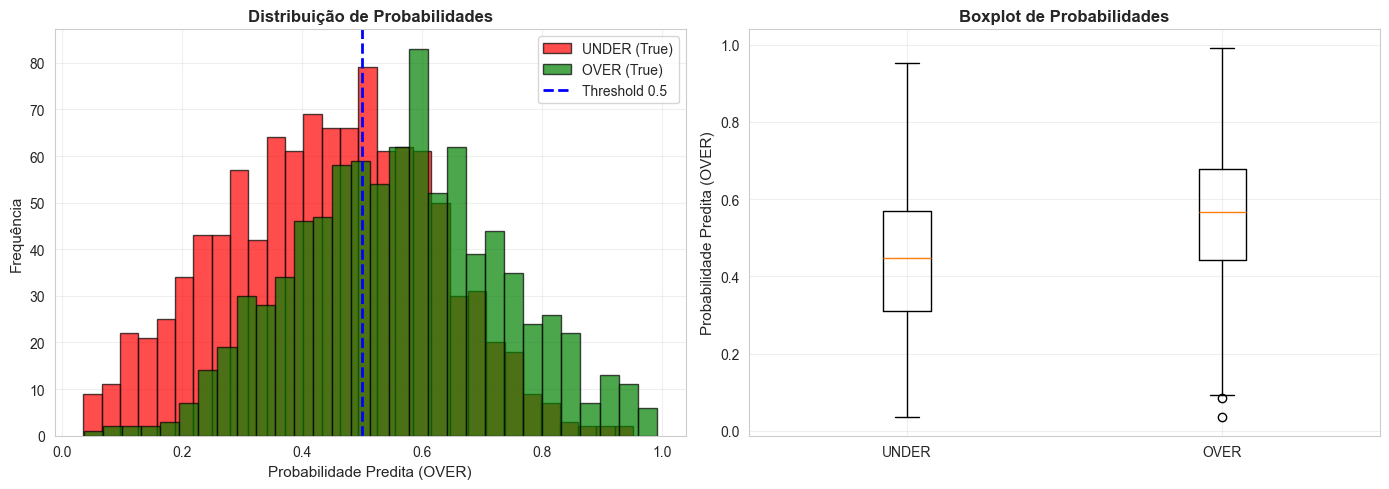


Estatísticas de Probabilidades:
UNDER (True):
  Média: 0.4415
  Mediana: 0.4486
  Std: 0.1744

OVER (True):
  Média: 0.5624
  Mediana: 0.5659
  Std: 0.1725


In [16]:
# Histograma de probabilidades
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, label='UNDER (True)', color='red', edgecolor='black')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, label='OVER (True)', color='green', edgecolor='black')
plt.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Threshold 0.5')
plt.xlabel('Probabilidade Predita (OVER)', fontsize=11)
plt.ylabel('Frequência', fontsize=11)
plt.title('Distribuição de Probabilidades', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot([y_pred_proba[y_test == 0], y_pred_proba[y_test == 1]], 
            labels=['UNDER', 'OVER'])
plt.ylabel('Probabilidade Predita (OVER)', fontsize=11)
plt.title('Boxplot de Probabilidades', fontsize=12, fontweight='bold')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas
print("\nEstatísticas de Probabilidades:")
print(f"UNDER (True):")
print(f"  Média: {np.mean(y_pred_proba[y_test == 0]):.4f}")
print(f"  Mediana: {np.median(y_pred_proba[y_test == 0]):.4f}")
print(f"  Std: {np.std(y_pred_proba[y_test == 0]):.4f}")
print(f"\nOVER (True):")
print(f"  Média: {np.mean(y_pred_proba[y_test == 1]):.4f}")
print(f"  Mediana: {np.median(y_pred_proba[y_test == 1]):.4f}")
print(f"  Std: {np.std(y_pred_proba[y_test == 1]):.4f}")

## 12. Análise por Liga

Métricas por Liga (Test Set):
AL                  : Acc=0.673, Prec=0.677, Rec=0.778, F1=0.724, ROC=0.719, N=49
ASI                 : Acc=0.375, Prec=0.000, Rec=0.000, F1=0.000, ROC=0.500, N=8
Asia Master         : Acc=0.667, Prec=0.583, Rec=0.538, F1=0.560, ROC=0.731, N=33
CD                  : Acc=0.712, Prec=0.810, Rec=0.500, F1=0.618, ROC=0.741, N=73
CT                  : Acc=0.714, Prec=0.857, Rec=0.667, F1=0.750, ROC=0.844, N=14
DCup                : Acc=0.824, Prec=0.857, Rec=0.750, F1=0.800, ROC=0.931, N=17
EBL                 : Acc=0.657, Prec=0.778, Rec=0.636, F1=0.700, ROC=0.738, N=35
EM                  : Acc=0.551, Prec=0.500, Rec=0.484, F1=0.492, ROC=0.514, N=69
EWC                 : Acc=0.333, Prec=0.333, Rec=1.000, F1=0.500, ROC=0.500, N=3
FST                 : Acc=0.714, Prec=0.800, Rec=0.800, F1=0.800, ROC=0.800, N=7
HC                  : Acc=0.800, Prec=0.684, Rec=0.867, F1=0.765, ROC=0.904, N=40
HLL                 : Acc=0.617, Prec=0.583, Rec=0.636, F1=0.609, ROC=0

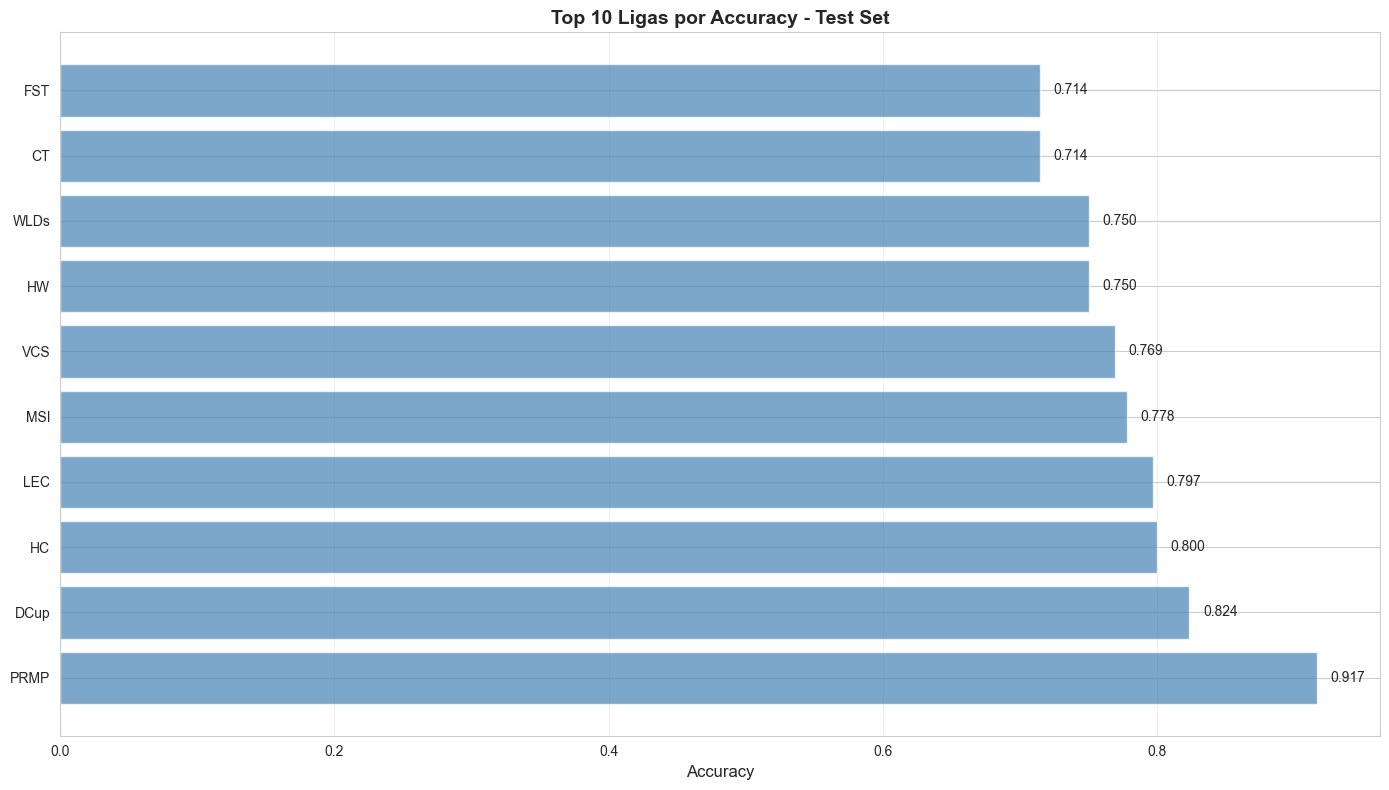

In [17]:
# Carrega dados originais para análise por liga
df_original = pd.read_csv("data_2025_transformed.csv")

# Cria dataframe de análise usando os índices do test set
df_analysis = pd.DataFrame(index=test_idx)
df_analysis['y_test'] = y_test
df_analysis['y_pred'] = y_pred
df_analysis['y_pred_proba'] = y_pred_proba

# Adiciona informações da liga do dataframe original
df_analysis['league'] = df_original.loc[test_idx, 'league'].values

# Métricas por liga (apenas test set)
print("Métricas por Liga (Test Set):")
print("=" * 80)
league_metrics = []

for league in sorted(df_analysis['league'].unique()):
    league_data = df_analysis[df_analysis['league'] == league]
    if len(league_data) > 0:
        league_y_test = league_data['y_test'].values
        league_y_pred = league_data['y_pred'].values
        league_y_proba = league_data['y_pred_proba'].values
        
        if len(np.unique(league_y_test)) > 1:  # Precisa ter ambas as classes
            acc = accuracy_score(league_y_test, league_y_pred)
            prec = precision_score(league_y_test, league_y_pred, zero_division=0)
            rec = recall_score(league_y_test, league_y_pred, zero_division=0)
            f1 = f1_score(league_y_test, league_y_pred, zero_division=0)
            
            try:
                roc = roc_auc_score(league_y_test, league_y_proba)
            except:
                roc = 0.0
            
            league_metrics.append({
                'league': league,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'f1': f1,
                'roc_auc': roc,
                'samples': len(league_data)
            })
            
            print(f"{league:20s}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}, ROC={roc:.3f}, N={len(league_data)}")

# Cria DataFrame com métricas por liga
if league_metrics:
    league_metrics_df = pd.DataFrame(league_metrics)
    
    # Visualização: Top 10 ligas por accuracy
    top_leagues = league_metrics_df.nlargest(10, 'accuracy')
    
    plt.figure(figsize=(14, 8))
    x_pos = np.arange(len(top_leagues))
    plt.barh(x_pos, top_leagues['accuracy'], alpha=0.7, color='steelblue')
    plt.yticks(x_pos, top_leagues['league'])
    plt.xlabel('Accuracy', fontsize=12)
    plt.title('Top 10 Ligas por Accuracy - Test Set', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    for i, v in enumerate(top_leagues['accuracy']):
        plt.text(v + 0.01, i, f'{v:.3f}', va='center')
    plt.tight_layout()
    plt.show()

## 13. Teste de Predição

In [18]:
# Usa o modelo já treinado nesta sessão
# Carrega dados necessários
with open(DATA_DIR / "champion_impacts.pkl", "rb") as f:
    champion_impacts_loaded = pickle.load(f)
league_stats_loaded = league_stats
feature_columns_loaded = list(features_df.columns)

# Função auxiliar para criar features
def create_features_from_game_local(game_data, league_stats, champion_impacts, feature_columns):
    league = game_data['league']
    league_impacts = champion_impacts.get(league, {})
    
    def normalize_champ(champ):
        if not champ:
            return ''
        return str(champ).strip()
    
    top_t1_impact = league_impacts.get(normalize_champ(game_data.get('top_t1', '')), 0.0)
    jung_t1_impact = league_impacts.get(normalize_champ(game_data.get('jung_t1', '')), 0.0)
    mid_t1_impact = league_impacts.get(normalize_champ(game_data.get('mid_t1', '')), 0.0)
    adc_t1_impact = league_impacts.get(normalize_champ(game_data.get('adc_t1', '')), 0.0)
    sup_t1_impact = league_impacts.get(normalize_champ(game_data.get('sup_t1', '')), 0.0)
    
    top_t2_impact = league_impacts.get(normalize_champ(game_data.get('top_t2', '')), 0.0)
    jung_t2_impact = league_impacts.get(normalize_champ(game_data.get('jung_t2', '')), 0.0)
    mid_t2_impact = league_impacts.get(normalize_champ(game_data.get('mid_t2', '')), 0.0)
    adc_t2_impact = league_impacts.get(normalize_champ(game_data.get('adc_t2', '')), 0.0)
    sup_t2_impact = league_impacts.get(normalize_champ(game_data.get('sup_t2', '')), 0.0)
    
    team1_avg_impact = np.mean([top_t1_impact, jung_t1_impact, mid_t1_impact, adc_t1_impact, sup_t1_impact])
    team2_avg_impact = np.mean([top_t2_impact, jung_t2_impact, mid_t2_impact, adc_t2_impact, sup_t2_impact])
    impact_diff = team1_avg_impact - team2_avg_impact
    
    league_mean = league_stats.get(league, {}).get('mean', 0.0)
    league_std = league_stats.get(league, {}).get('std', 0.0)
    
    feature_dict = {
        'league_mean': league_mean,
        'league_std': league_std,
        'team1_avg_impact': team1_avg_impact,
        'team2_avg_impact': team2_avg_impact,
        'impact_diff': impact_diff,
        'top_t1_impact': top_t1_impact,
        'jung_t1_impact': jung_t1_impact,
        'mid_t1_impact': mid_t1_impact,
        'adc_t1_impact': adc_t1_impact,
        'sup_t1_impact': sup_t1_impact,
        'top_t2_impact': top_t2_impact,
        'jung_t2_impact': jung_t2_impact,
        'mid_t2_impact': mid_t2_impact,
        'adc_t2_impact': adc_t2_impact,
        'sup_t2_impact': sup_t2_impact,
    }
    
    for col in feature_columns:
        if col.startswith('league_') and col != 'league_mean' and col != 'league_std':
            liga_name = col.replace('league_', '')
            feature_dict[col] = 1.0 if liga_name == league else 0.0
    
    features = np.array([feature_dict.get(col, 0.0) for col in feature_columns])
    return features.reshape(1, -1)

# Exemplo de jogo
game_example = {
    'league': 'LCK',
    'top_t1': 'Aatrox',
    'jung_t1': 'Graves',
    'mid_t1': 'Azir',
    'adc_t1': 'Jinx',
    'sup_t1': 'Thresh',
    'top_t2': 'Gnar',
    'jung_t2': 'Sejuani',
    'mid_t2': 'Orianna',
    'adc_t2': 'Aphelios',
    'sup_t2': 'Braum'
}

# Predição para média da liga usando modelo da sessão
X_game = create_features_from_game_local(game_example, league_stats_loaded, 
                                         champion_impacts_loaded, feature_columns_loaded)
X_game_scaled = scaler.transform(X_game)
prob_over = model.predict_proba(X_game_scaled)[0, 1]

pred_mean = {
    'league_mean': league_stats_loaded.get(game_example['league'], {}).get('mean', 0.0),
    'probability_over_mean': prob_over,
    'probability_under_mean': 1 - prob_over,
    'prediction': 'OVER' if prob_over >= 0.5 else 'UNDER',
    'confidence': 'High' if prob_over >= 0.70 or prob_over <= 0.30 else 'Medium'
}

print("Exemplo de Predição:")
print(f"Liga: {game_example['league']}")
print(f"Média da liga: {pred_mean['league_mean']:.2f} kills")
print(f"Probabilidade OVER média: {pred_mean['probability_over_mean']:.1%}")
print(f"Predição: {pred_mean['prediction']} (Confiança: {pred_mean['confidence']})")

# Predição para linha específica
betting_line = 28.5
league_mean = league_stats_loaded.get(game_example['league'], {}).get('mean', 0.0)
league_std = league_stats_loaded.get(game_example['league'], {}).get('std', 1.0)
prob_over_mean = pred_mean['probability_over_mean']

if league_std > 0:
    z_score = (betting_line - league_mean) / league_std
    adjustment = 1 / (1 + np.exp(-z_score * 0.5))
    if betting_line > league_mean:
        prob_over_line = prob_over_mean * (1 - adjustment * 0.3)
    else:
        prob_over_line = prob_over_mean + (1 - prob_over_mean) * adjustment * 0.3
    prob_over_line = np.clip(prob_over_line, 0.0, 1.0)
else:
    prob_over_line = prob_over_mean

pred_line = {
    'probability_over_line': prob_over_line,
    'probability_under_line': 1 - prob_over_line,
    'bet_over': prob_over_line >= 0.55,
    'bet_under': (1 - prob_over_line) >= 0.55
}

print(f"\nPara linha da casa {betting_line}:")
print(f"Probabilidade OVER {betting_line}: {pred_line['probability_over_line']:.1%}")
if pred_line['bet_over']:
    print(f"Recomendação: APOSTAR OVER {betting_line}")
elif pred_line['bet_under']:
    print(f"Recomendação: APOSTAR UNDER {betting_line}")

Exemplo de Predição:
Liga: LCK
Média da liga: 28.81 kills
Probabilidade OVER média: 26.4%
Predição: UNDER (Confiança: High)

Para linha da casa 28.5:
Probabilidade OVER 28.5: 37.3%
Recomendação: APOSTAR UNDER 28.5


## 14. Resumo Final e Recomendações

In [19]:
print("=" * 70)
print("RESUMO FINAL DO MODELO 2025")
print("=" * 70)
print(f"\nDataset:")
print(f"  Total de amostras: {len(features_df)}")
print(f"  Train: {len(X_train)}")
print(f"  Test: {len(X_test)}")
print(f"  Ligas: {len(league_stats)}")

print(f"\nPerformance (Threshold 0.5):")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  ROC-AUC:    {roc_auc:.4f}")
print(f"  Precision:  {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:     {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:   {f1:.4f}")

# Melhor threshold encontrado
try:
    print(f"\nMelhor Threshold (Accuracy): {results_df.loc[best_acc_idx, 'threshold']:.3f}")
    print(f"  Accuracy: {results_df.loc[best_acc_idx, 'accuracy']:.4f}")
    print(f"\nMelhor Threshold (Precision): {results_df.loc[best_prec_idx, 'threshold']:.3f}")
    print(f"  Precision: {results_df.loc[best_prec_idx, 'precision']:.4f}")
except:
    print(f"\nMelhor Threshold: 0.50 (padrão)")

print(f"\nRecomendações para Apostas:")
print(f"  - UNDER: Use threshold de 60%+ para maior precisão")
print(f"  - OVER: Use threshold de 65%+ para compensar menor precisão")
print(f"  - Alta confiança (70%+): Aposte 2-3% da banca")
print(f"  - Média confiança (60-70%): Aposte 1-2% da banca")
print(f"  - Evite apostar com probabilidade < 60%")

print(f"\nModelo treinado com sucesso e pronto para uso!")

RESUMO FINAL DO MODELO 2025

Dataset:
  Total de amostras: 9806
  Train: 7844
  Test: 1962
  Ligas: 44

Performance (Threshold 0.5):
  Accuracy:  0.6193 (61.93%)
  ROC-AUC:    0.6833
  Precision:  0.5735 (57.35%)
  Recall:     0.6345 (63.45%)
  F1-Score:   0.7619

Melhor Threshold (Accuracy): 0.560
  Accuracy: 0.6346

Melhor Threshold (Precision): 0.960
  Precision: 1.0000

Recomendações para Apostas:
  - UNDER: Use threshold de 60%+ para maior precisão
  - OVER: Use threshold de 65%+ para compensar menor precisão
  - Alta confiança (70%+): Aposte 2-3% da banca
  - Média confiança (60-70%): Aposte 1-2% da banca
  - Evite apostar com probabilidade < 60%

Modelo treinado com sucesso e pronto para uso!
